In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from pycbc.filter import sigma
from pycbc.noise import frequency_noise_from_psd, noise_from_psd
from simple_pe.waveforms import calculate_mode_snr, network_mode_snr
from calcwf import *
from interpolating_match import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


In [2]:
# Waveform parameters
n = 6
zero_ecc_chirp = 24.16193848
fid_e = zero_ecc_chirp2fid_e(0.0730036413528654, scaling_norms=[10, 0.035])
fid_chirp = chirp_degeneracy_line(zero_ecc_chirp, fid_e)
f_match = 20
ifos=['H1']

# Generate harmonics
all_wfs = list(get_h([1]*n, 10, fid_e, chirp2total(fid_chirp, 2), 2, 4096))
wfs = {'h0': all_wfs[1], 'h1': all_wfs[2], 'h-1': all_wfs[3], 'h2': all_wfs[4]}
for key in wfs:
    wfs[key].start_time = 1
    wfs[key].prepend_zeros(4096)
    wfs[key].resize(16*4096)
wfs_f = {}
for key in wfs:
    wfs_f[key] = wfs[key].real().to_frequencyseries()
psd = gen_psd(wfs['h0'], 10)

# Normalise waveform modes
h_perp = {}
h_perp_f = {}
for key in wfs.keys():
    norm = sigma(wfs_f[key], psd, low_frequency_cutoff=f_match, high_frequency_cutoff=psd.sample_frequencies[-1])
    h_perp[key] = wfs[key] / norm
    h_perp_f[key] = wfs_f[key] / norm

mode_data = 5*h_perp['h0'] + 2*h_perp['h1'] + 1*h_perp['h-1'] + 1*h_perp['h2']
mode_data_f = mode_data.real().to_frequencyseries()

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


In [19]:
SNRs = {'h0': [], 'h1': [], 'h-1': [], 'h2': []}
h1_hn1_pc_SNRs = []
h1_hn1_h2_pc_SNRs = []
n = 1000
for i in range(n):

    # Create noise and add modes to boost SNR
    gaussian_data = mode_data_f + frequency_noise_from_psd(psd)
    
    # Calculate mode SNRs
    mode_SNRs, _ = calculate_mode_snr(gaussian_data, psd, h_perp_f, 16-1/8192, 16, f_match, h_perp.keys(), dominant_mode='h0')
    z = {'H1': mode_SNRs}
    
    # Calculate network SNRs
    rss_snr, _ = network_mode_snr(z, ['H1'], z[ifos[0]].keys(), dominant_mode='h0')
    for key in rss_snr:
        SNRs[key].append(rss_snr[key])

    # Calculate phase consistent combinations
    cplx_SNRs = [mode_SNRs['h0'], mode_SNRs['h1'], mode_SNRs['h-1'], mode_SNRs['h2']]
    frac, denom = comb_harm_consistent(np.abs(cplx_SNRs[:-1]), np.angle(cplx_SNRs[:-1]), harms=[0,1,-1], return_denom=True)
    h1_hn1_pc_SNRs.append(frac*denom)
    frac, denom = comb_harm_consistent(np.abs(cplx_SNRs), np.angle(cplx_SNRs), harms=[0,1,-1,2], return_denom=True)
    h1_hn1_h2_pc_SNRs.append(frac*denom)

    # Progress bar
    if i%100 == 0:
        print(f'\r{i} done out of {n}.', end='')

print(f'\r{n} done out of {n}.')

# Convert to np arrays
for key in SNRs.keys():
    SNRs[key] = np.array(SNRs[key])

# Calculate actual SNRs in mode_data_f
mode_SNRs, _ = calculate_mode_snr(mode_data_f, psd, h_perp_f, 16-1/8192, 16, f_match, h_perp.keys(), dominant_mode='h0')
z = {'H1': mode_SNRs}
ncs, _ = network_mode_snr(z, ['H1'], z[ifos[0]].keys(), dominant_mode='h0')

1000 done out of 1000.


In [ ]:
df = 2
x_arr = np.linspace(0, 80, 201)

for i, key in enumerate(SNRs.keys()):

    # Plot histograms of mode SNRs
    plt.hist(SNRs[key]**2, histtype='step', density=True, color=f'C{i}', label=key, bins=30)
    
    # Plot chi^2 distribution with 2 d.o.f
    nc = ncs[key]
    pdf = ncx2.pdf(x_arr, df, nc)
    area = quad(lambda x: ncx2.pdf(x, df, nc), 0, 80)[0]
    pdf /= area
    plt.plot(x_arr, pdf, c=f'C{i}', ls='dashed')

# Plot formatting
plt.legend()
plt.xlim(0, 20)
plt.xlabel('SNR^2')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

All modes should follow a non central chi squared distribution with 2 degrees of freedom. The non-centrality parameter is the actual SNR found with zero noise. The above plot (even with just 100 samples) shows that this is a pretty good description.

Now let's look at what happens when we want to combine the SNR of multiple harmonics.

Text(0, 0.5, 'Density')

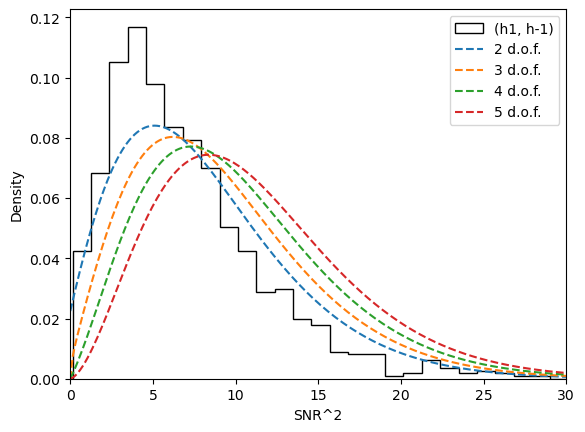

In [55]:
# Plot histograms of mode SNRs
plt.hist(SNRs['h1']**2+SNRs['h-1']**2, histtype='step', density=True, color='k', label='(h1, h-1)', bins=30)
    
# Plot chi^2 distribution with 2, 3, 4 d.o.f
nc = ncs['h1']**2+ncs['h-1']**2
x_arr = np.linspace(0, 30, 201)
for df in range(2,6):
    pdf = ncx2.pdf(x_arr, df, nc)
    area = quad(lambda x: ncx2.pdf(x, df, nc), 0, 30)[0]
    pdf /= area
    plt.plot(x_arr, pdf, ls='dashed', label=f'{df} d.o.f.')

# Plot formatting
plt.legend()
plt.xlim(0, 30)
plt.xlabel('SNR^2')
plt.ylabel('Density')

4 degrees of freedom looks sensible as expected. Let's compare this to what happens when we apply our phase consistency algorithm to the combination of these two harmonics.

Text(0, 0.5, 'Density')

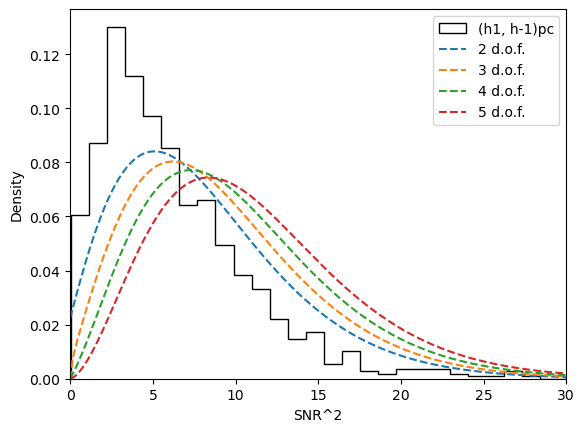

In [54]:
# Plot histograms of mode SNRs
plt.hist(np.array(h1_hn1_pc_SNRs)**2, histtype='step', density=True, color='k', label='(h1, h-1)pc', bins=30)
    
# Plot chi^2 distribution with 2, 3, 4 d.o.f
nc = ncs['h1']**2+ncs['h-1']**2
x_arr = np.linspace(0, 30, 201)
for df in range(2,6):
    pdf = ncx2.pdf(x_arr, df, nc)
    area = quad(lambda x: ncx2.pdf(x, df, nc), 0, 30)[0]
    pdf /= area
    plt.plot(x_arr, pdf, ls='dashed', label=f'{df} d.o.f.')

# Plot formatting
plt.legend()
plt.xlim(0, 30)
plt.xlabel('SNR^2')
plt.ylabel('Density')

Let's repeat both of these plots when adding h2 as well.

Text(0, 0.5, 'Density')

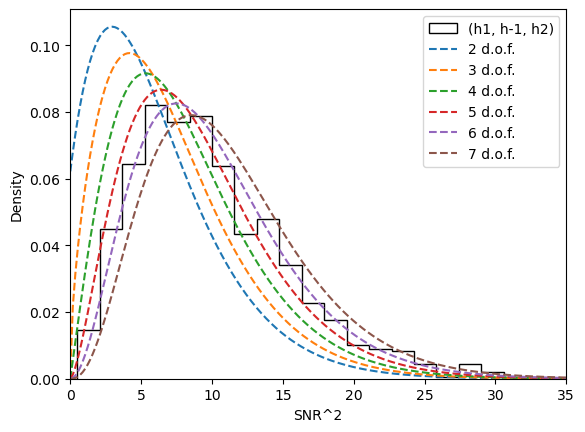

In [42]:
# Plot histograms of mode SNRs
plt.hist(SNRs['h1']**2+SNRs['h-1']**2+SNRs['h2']**2, histtype='step', density=True, color='k', label='(h1, h-1, h2)', bins=30)
    
# Plot chi^2 distribution with 2, 3, 4 d.o.f
nc = ncs['h1']**2+ncs['h-1']**2+ncs['h2']**2
x_arr = np.linspace(0, 35, 201)
for df in range(2,8):
    pdf = ncx2.pdf(x_arr, df, nc)
    area = quad(lambda x: ncx2.pdf(x, df, nc), 0, 35)[0]
    pdf /= area
    plt.plot(x_arr, pdf, ls='dashed', label=f'{df} d.o.f.')

# Plot formatting
plt.legend()
plt.xlim(0, 35)
plt.xlabel('SNR^2')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

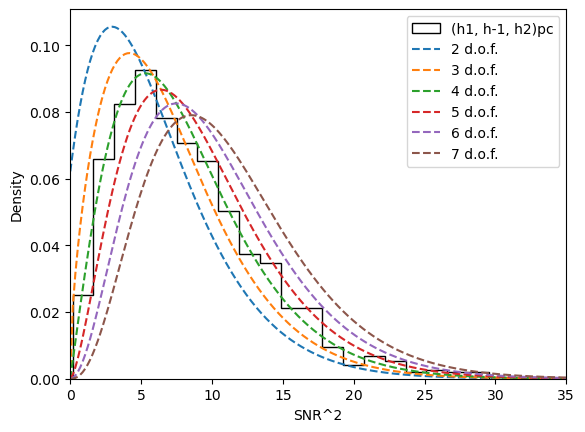

In [44]:
# Plot histograms of mode SNRs
plt.hist(np.array(h1_hn1_h2_pc_SNRs)**2, histtype='step', density=True, color='k', label='(h1, h-1, h2)pc', bins=30)
    
# Plot chi^2 distribution with 2, 3, 4 d.o.f
nc = ncs['h1']**2+ncs['h-1']**2+ncs['h2']**2
x_arr = np.linspace(0, 35, 201)
for df in range(2,8):
    pdf = ncx2.pdf(x_arr, df, nc)
    area = quad(lambda x: ncx2.pdf(x, df, nc), 0, 35)[0]
    pdf /= area
    plt.plot(x_arr, pdf, ls='dashed', label=f'{df} d.o.f.')

# Plot formatting
plt.legend()
plt.xlim(0, 35)
plt.xlabel('SNR^2')
plt.ylabel('Density')